In [37]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import time

In [38]:
class chessds(Dataset):
    def __init__(self):
        self.length = 20000

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        index = (idx // 1000) * 1000
        filename = f"{index}.npy"
        data = np.load(filename)
        data_select = data[idx%1000, :, :, :]
        label = torch.tensor([(data_select[17,0,0])])
        return torch.from_numpy(data_select[:17,:,:]).float(), float(label.unsqueeze(0))

In [39]:
ds = chessds()
ds.__getitem__(0)[0].shape

torch.Size([17, 8, 8])

In [40]:
def get_data_loader(batch_size):
  dataset = chessds()
  total_size = len(dataset)
  train_size = int(0.6 * total_size)
  valid_size = int(0.2 * total_size)
  test_size = total_size - train_size - valid_size


  train_dataset, valid_dataset, test_dataset = random_split(
      dataset, [train_size, valid_size, test_size]
  )

  train_loader = DataLoader(
      train_dataset, batch_size= batch_size, shuffle=True
  )
  valid_loader = DataLoader(
      valid_dataset, batch_size = batch_size, shuffle=True
  )
  test_loader = DataLoader(
      test_dataset, batch_size = batch_size,  shuffle=True
  )
  return train_loader, valid_loader, test_loader

In [41]:
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [42]:
def train_net(net, batch_size=1, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.MSELoss()
    optimizer = SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = torch.reshape(labels, (1,1))
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "ismail"
        self.largeCNN = nn.Sequential( 
            nn.Conv2d(17, 17, 8)
        )
        self.smallCNN = nn.Sequential( 
            nn.Conv2d(17, 4, 3) # out is 4 x 6 x 6
        )
        self.out = nn.Sequential(
            nn.Sigmoid()
        )
        self.fc1 = nn.Linear(17*1, 1)
        self.fc2 = nn.Linear(4*6*6, 1)
    def forward(self, x):
        x1 = self.largeCNN(x).view(-1, 17*1)
        x1 = self.fc1(x1)
        x2 = self.smallCNN(x).view(-1, 4*6*6)
        x2 = self.fc2(x2)
        x = self.out(x1 + x2)
        return x
neuralnet = CNN()

In [44]:
for param in neuralnet.parameters():
    print(param.shape)

torch.Size([17, 17, 8, 8])
torch.Size([17])
torch.Size([4, 17, 3, 3])
torch.Size([4])
torch.Size([1, 17])
torch.Size([1])
torch.Size([1, 144])
torch.Size([1])


In [45]:
train_net(neuralnet, num_epochs = 2)

Epoch 1: Train err: 0.5316666666666666, Train loss: 0.9499163012405426 |Validation err: 0.5235, Validation loss: 0.9286850136198508
Epoch 2: Train err: 0.7245833333333334, Train loss: 0.92460083755838 |Validation err: 0.595, Validation loss: 0.9636275146026921
Epoch 3: Train err: 0.5963333333333334, Train loss: 1.1809198119053252 |Validation err: 0.79675, Validation loss: 0.9213743018376596
Epoch 4: Train err: 0.7963333333333333, Train loss: 0.9310399950330176 |Validation err: 0.79025, Validation loss: 0.9455973982526422
Epoch 5: Train err: 0.7896666666666666, Train loss: 0.9209143185703982 |Validation err: 0.773, Validation loss: 0.9378349997652683
Finished Training
Total time elapsed: 291.99 seconds


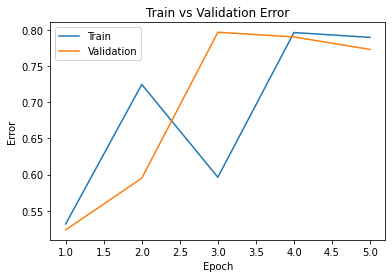

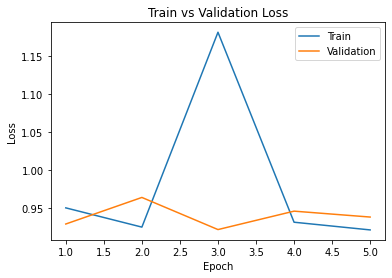

In [47]:
small_model_path = get_model_name("ismail", batch_size=1, learning_rate=0.01, epoch=4)
plot_training_curve(small_model_path)
